In [1]:
## Figure 16. Comparing InSAR Time-series with GPS Time-series

import os
import sys
import time
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, giantTimeseries
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet
from pysar.objects.gps import gps
from pysar import view

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/insar_vs_gps')
os.chdir(work_dir)
print('Go to directory: '+work_dir)
gps_dir = '~/insarlab/Galapagos/GPS'
gps_site_list_file = os.path.join(gps_dir, 'DataHoldings.txt')

site_r = 'GV01' #'TOUO' #'ISCO'  'GV01'  'GV07'  None

pysar_dir = '~/insarlab/Galapagos/GalapagosSenDT128/PYSAR'
#pysar_dir = '~/insarlab/Galapagos/GalapagosSenDT128/PYSAR_IW1'
pysar_dir = os.path.expanduser(pysar_dir)
ts_file = os.path.join(pysar_dir, 'timeseries_ECMWF_demErr_ramp.h5')
ts_obj = timeseries(ts_file)
unit_fac = 1.

#ts_file = os.path.join(pysar_dir, '../GIANT/Stack/LS-PARAMS.h5')
##ts_file = os.path.join(pysar_dir, '../GIANT/Stack/TS-PARAMS.h5')
#ts_obj = giantTimeseries(ts_file)
#unit_fac = 0.001

mask_file = os.path.join(pysar_dir, 'maskTempCoh.h5')
mask = readfile.read(mask_file)[0]

geom_file = os.path.join(pysar_dir, 'INPUTS/geometryRadar.h5')
ts_obj.open(print_msg=False)
atr = ts_obj.metadata

temp_coh_file = os.path.join(pysar_dir, 'temporalCoherence.h5')
temp_coh = readfile.read(temp_coh_file)[0]

t0 = ts_obj.times[0] - relativedelta(months=2)
t1 = ts_obj.times[-1] + relativedelta(months=2)
start_date = t0.strftime('%Y%m%d')
end_date = t1.strftime('%Y%m%d')
start_date = '20141101'
end_date = '20180625'

def read_timeseries(site, site_r=None):
    ## Read GPS
    gps_obj = gps(site, data_dir=gps_dir)
    (gps_times,
     gps_dis,
     gps_std,
     site_lalo,
     ref_site_lalo) = gps_obj.read_gps_los_displacement(geom_file, start_date, end_date,
                                                        ref_site=site_r,
                                                        gps_comp='enu2los')

    ## Read InSAR
    coord = ut.coordinate(atr, lookup_file=geom_file)
    y, x = coord.geo2radar(site_lalo[0], site_lalo[1], print_msg=False)[0:2]
    lalo = coord.radar2geo(y,x,print_msg=False)[0:2]
    box = (x, y, x+1, y+1)
    pysar_dis = readfile.read(ts_file, box=box, print_msg=False)[0] * unit_fac
    pysar_times = ts_obj.times

    if site_r:
        try:
            ref_y, ref_x = coord.geo2radar(ref_site_lalo[0], ref_site_lalo[1], print_msg=False)[0:2]
        except:
            ref_y, ref_x = -1, -1
        if 0 <= ref_x < int(atr['WIDTH']) and 0<= ref_y < int(atr['LENGTH']):
            ref_box = (ref_x, ref_y, ref_x+1, ref_y+1)
            pysar_dis -= readfile.read(ts_file, box=ref_box, print_msg=False)[0] * unit_fac

    # common reference date
    comm_idx = 2
    while comm_idx < len(pysar_times):
        if pysar_times[comm_idx] not in gps_times:
            comm_idx += 1
        else:
            break
    if comm_idx == len(pysar_times):
        raise RuntimeError('InSAR and GPS do not share ANY date for site: {}'.format(site))

    comm_date = pysar_times[comm_idx]
    pysar_dis -= pysar_dis[comm_idx]
    print('reference date:', comm_date)

    comm_idx_gps = np.where(gps_times == comm_date)[0][0]
    gps_dis -= gps_dis[comm_idx_gps]
    gps_std = np.sqrt(gps_std**2 + gps_std[comm_idx_gps]**2)

    dis_rmse = get_timeseries_rmse(gps_times, gps_dis, pysar_times, pysar_dis) * 100.

    gps_data = {}
    gps_data['site'] = site
    gps_data['lalo'] = site_lalo
    gps_data['datetime'] = gps_times
    gps_data['displacement'] = gps_dis
    gps_data['displacement_std'] = gps_std

    insar_data = {}
    insar_data['datetime'] = pysar_times
    insar_data['displacement'] = pysar_dis
    insar_data['temporalCoherence'] = temp_coh[y, x]

    print('site: {}, temp_coh: {:.4f}, rmse: {:.4f} cm'.format(site, temp_coh[y, x], dis_rmse))
    return gps_data, insar_data, dis_rmse


def get_timeseries_rmse(gps_times, gps_dis, pysar_times, pysar_dis):
    comm_dates = np.array(sorted(list(set(gps_times) & set(pysar_times))))
    num_date = len(comm_dates)
    dis_diff = np.zeros(num_date, np.float32)
    for i in range(num_date):
        idx1 = np.where(gps_times   == comm_dates[i])[0][0]
        idx2 = np.where(pysar_times == comm_dates[i])[0][0]
        dis_diff[i] = gps_dis[idx1] - pysar_dis[idx2]
    dis_rmse = np.sqrt(np.sum(np.square(dis_diff)) / (num_date - 1))
    return dis_rmse


## Plot
def plot_timeseries(ax, site, gps_data, insar_data, rmse=0., site_r=None, offset=0.):
    # GPS
    ax.errorbar(gps_data['datetime'],
                gps_data['displacement']-offset,
                yerr=gps_data['displacement_std']*3.,
                ms=marker_size*0.5, lw=0, alpha=1.,
                elinewidth=edge_width*0.5,  ecolor=pp.mplColors[0],
                capsize=marker_size*0.5*0.5, markeredgewidth=edge_width*0.5,
                label='GPS', zorder=1)
    # InSAR
    if insar_data['temporalCoherence'] < 0.7:
        ecolor = 'gray'
    else:
        ecolor = pp.mplColors[1]
    ax.scatter(insar_data['datetime'],
               insar_data['displacement']-offset,
               s=5**2, label='InSAR',
               facecolors='none', edgecolors=ecolor, linewidth=1., alpha=0.7, zorder=2)
    # Label
    ax.annotate('{}-{} ({:.2f})'.format(site, site_r, insar_data['temporalCoherence']),
                xy=(1.03, insar_data['displacement'][-1] - offset),
                xycoords=ax.get_yaxis_transform(),  # y in data untis, x in axes fraction
                color='k', fontsize=font_size)
    ax.annotate('{:.1f}'.format(rmse),
                xy=(0.05, insar_data['displacement'][0] - offset + 0.1),
                xycoords=ax.get_yaxis_transform(),  # y in data untis, x in axes fraction
                color='k', fontsize=font_size)
    return ax

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/insar_vs_gps


reference date: 2015-03-07 00:00:00
site: GV05, temp_coh: 0.9981, rmse: 1.6924 cm
reference date: 2015-03-07 00:00:00
site: GV04, temp_coh: 0.9987, rmse: 0.6138 cm
reference date: 2015-03-07 00:00:00
site: GV06, temp_coh: 0.9984, rmse: 2.3871 cm
reference date: 2015-03-07 00:00:00
site: GV09, temp_coh: 0.9208, rmse: 3.3714 cm
reference date: 2015-03-07 00:00:00
site: GV03, temp_coh: 0.9971, rmse: 0.7637 cm
reference date: 2015-03-07 00:00:00
site: GV08, temp_coh: 0.9913, rmse: 2.2882 cm
reference date: 2015-03-07 00:00:00
site: GV07, temp_coh: 0.9935, rmse: 0.9919 cm
reference date: 2015-03-07 00:00:00
site: GV10, temp_coh: 0.6745, rmse: 2.9756 cm
Done.


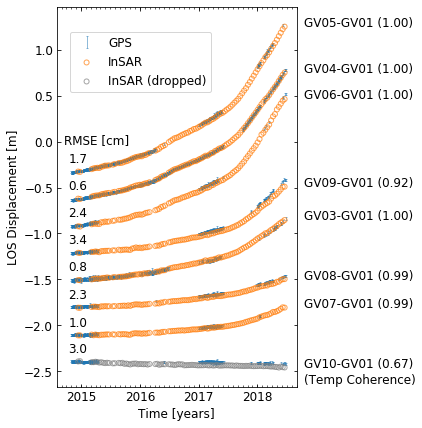

In [6]:
## Figure 6 (b) - Displacement Time-series from InSAR and GPS

gps_sites = ['GV05', 'GV04', 'GV06', 'GV09', 'GV03', 'GV08', 'GV07', 'GV01', 'GV10']
if site_r in gps_sites:
    gps_sites.remove(site_r)

offset = 0.3
offi = 0.
fig, ax = plt.subplots(figsize=(4.3, 7))
for i in range(len(gps_sites)):
    (gps_data,
     insar_data,
     dis_rmse) = read_timeseries(site=gps_sites[i], site_r=site_r)

    if not np.all(np.isnan(insar_data['displacement'])):
        offi += offset
        ax = plot_timeseries(ax, gps_sites[i], gps_data, insar_data, dis_rmse,
                             site_r=site_r, offset=offi)

ax = pp.auto_adjust_xaxis_date(ax, ts_obj.yearList)[0]
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('LOS Displacement [m]', fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.annotate('RMSE [cm]', xy=(0.03, 0.64), xycoords='axes fraction', fontsize=font_size, color='k')
ax.annotate('(Temp Coherence)',  xy=(1.03, 0.01), xycoords='axes fraction', fontsize=font_size, color='k')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[-1], handles[0], handles[int(len(handles)/2-1)]],
          ['GPS', 'InSAR', 'InSAR (dropped)'],
          loc='upper left', bbox_to_anchor=(0.03, 0.95), fontsize=font_size)
print('Done.')

plt.savefig('insar_vs_gps_point_ts.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

view.py /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/geo_timeseries_ECMWF_demErr_ramp.h5 20180619 --ref-date 20141213 --dem /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84 --dem-nocontour -m /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/geo_maskTempCoh.h5 --sub-lat -0.86 -0.77 --sub-lon -91.19 -91.07 -u m --vlim -0.1 2.4 --lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 0.2 0.85 0.07 --fontsize 12 --notitle --dpi 600 --cbar-nbins 4 --cbar-ext both --nomultilook --show-gps --gps-comp enu2los --ref-gps GV01 


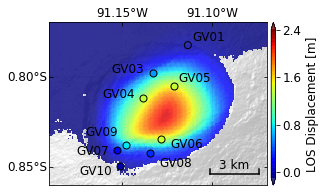

In [7]:
## Figure 6 (a) - InSAR velocity map with GPS location on Sierra Negra
pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
vel_file  = os.path.join(pysar_dir, 'geo_velocity_masked.h5')
dem_file  = os.path.join(pysar_dir, '../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84')
ts_file   = os.path.join(pysar_dir, 'geo_timeseries_ECMWF_demErr_ramp.h5')
mask_file = os.path.join(pysar_dir, 'geo_maskTempCoh.h5')

print_msg = False
fig, ax = plt.subplots(figsize=(5, 3))

# call view.py functions to plot InSAR background
cmd  = 'view.py {} 20180619 --ref-date 20141213 --dem {} --dem-nocontour -m {} '.format(ts_file, dem_file, mask_file)
cmd += '--sub-lat -0.86 -0.77 --sub-lon -91.19 -91.07 -u m --vlim -0.1 2.4 '
cmd += '--lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 0.2 0.85 0.07 '
cmd += '--fontsize 12 --notitle --dpi 600 '
cmd += '--cbar-nbins 4 --cbar-ext both --nomultilook '
cmd += '--show-gps --gps-comp enu2los --ref-gps GV01 '
print(cmd)
d_v, atr, inps = view.prep_slice(cmd, print_msg=print_msg)
inps.cbar_label = 'LOS Displacement [m]'
ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps, print_msg=print_msg)

# plot GPS label
gps_sites = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
lat_off = np.array([1,  0,  0,  1, -2,  -1, -3,   2,  -2,  1]) * 0.05 / 20.
lon_off = np.array([1, -9, -9,  1,  2,  -9,  2,  -9,  -9, -9]) * 0.05 / 20.

gps_lats = []
gps_lons = []
for site in gps_sites:
    lat, lon = gps(site=site, data_dir=gps_dir).get_stat_lat_lon(print_msg=print_msg)
    gps_lats.append(lat)
    gps_lons.append(lon)
for i in range(len(gps_sites)):
    ax.annotate(gps_sites[i], (gps_lons[i]+lon_off[i], gps_lats[i]+lat_off[i]), fontsize=font_size)

plt.savefig('insar_vs_gps_map.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

site: GV09, temp_coh: 0.9336, rmse: 1.0082 mm


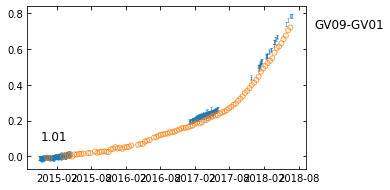

In [10]:
## plot single station timeseries - InSAR vs GPS
site = 'GV09'
site_r = 'GV01'
fig, ax = plt.subplots(figsize=(5, 3))

(gps_data,
 insar_data,
 dis_rmse) = read_timeseries(site=site, site_r=site_r)

if not np.all(np.isnan(insar_data['displacement'])):
    ax = plot_timeseries(ax, site, gps_data, insar_data, dis_rmse,
                         site_r=site_r, offset=0)

ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
#plt.savefig('{}-{}.jpg'.format(site, site_r), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

lat/lon: -0.7824/-91.1134, y/x: 1464/466
lat/lon: -0.7978/-91.1329, y/x: 1494/494
lat/lon: -0.8115/-91.1381, y/x: 1517/498
lat/lon: -0.8049/-91.1212, y/x: 1501/472
lat/lon: -0.8343/-91.1281, y/x: 1549/472
lat/lon: -0.8405/-91.1526, y/x: 1566/512
lat/lon: -0.8420/-91.1344, y/x: 1563/481
lat/lon: -0.8373/-91.1474, y/x: 1560/504
lat/lon: -0.8493/-91.1510, y/x: 1579/506


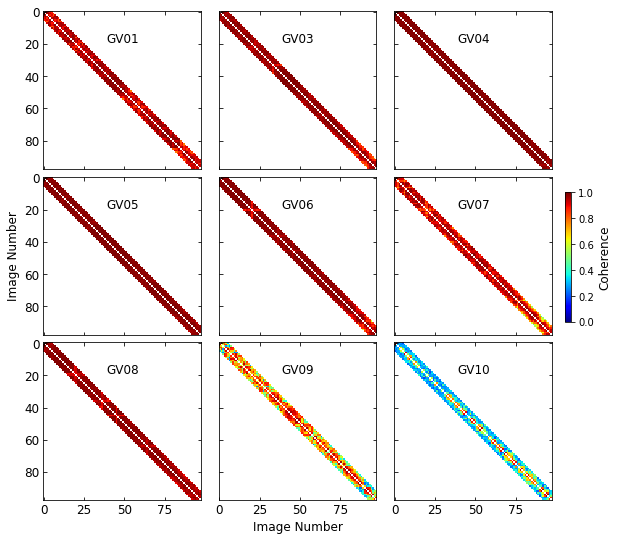

Done.


In [33]:
## Figure S3 - Coherence Matrix of InSAR observation on GPS sites

def get_site_coherence_matrix(site='GV01'):
    gps_obj = gps(site, data_dir=gps_dir)
    gps_obj.open(print_msg=False)

    ifg_file = os.path.join(pysar_dir, 'INPUTS/ifgramStack.h5')
    geom_file = os.path.join(pysar_dir, 'INPUTS/geometryRadar.h5')
    stack_obj = ifgramStack(ifg_file)
    stack_obj.open(print_msg=False)
    date12_list_all = stack_obj.get_date12_list(dropIfgram=True)

    coord = ut.coordinate(stack_obj.metadata, lookup_file=geom_file)
    y, x = coord.geo2radar(gps_obj.site_lat, gps_obj.site_lon, print_msg=False)[0:2]
    box = (x, y, x+1, y+1)
    dset_list = ['coherence-{}'.format(i) for i in date12_list_all]
    coh = np.squeeze(readfile.read(ifg_file, datasetName=dset_list, box=box, print_msg=False)[0])

    print('lat/lon: {:.4f}/{:.4f}, y/x: {}/{}'.format(gps_obj.site_lat, gps_obj.site_lon, y, x))

    coh_date12_list = list(np.array(date12_list_all)[np.array(coh) >= 0.25])
    date12_to_drop = sorted(list(set(date12_list_all) - set(coh_date12_list)))

    coh_mat = pnet.coherence_matrix(date12_list_all, coh.tolist())

    A = stack_obj.get_design_matrix4timeseries_estimation(date12_list = coh_date12_list)[0]
    if np.linalg.matrix_rank(A) < A.shape[1]:
        print('Singular design matrix!')
    return coh_mat

gps_sites = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[9, 9], sharex=True, sharey=True)
for i in range(len(gps_sites)):
    ax = axs.flatten()[i]
    site = gps_sites[i]
    coh_mat = get_site_coherence_matrix(site)
    im = ax.imshow(coh_mat, cmap='jet', vmin=0., vmax=1.)
    ax.tick_params(which='both', direction='in', labelsize=font_size,
                   bottom=True, top=True, left=True, right=True)
    ax.annotate(site, xy=(0.4, 0.8), color='k', xycoords='axes fraction', fontsize=font_size)
axs[1,0].set_ylabel('Image Number', fontsize=font_size)
axs[2,1].set_xlabel('Image Number', fontsize=font_size)

# colorbar
fig.subplots_adjust(right=0.93)
cax = fig.add_axes([0.94, 0.4, 0.01, 0.2])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Coherence', fontsize=font_size)

fig.subplots_adjust(wspace=0.03, hspace=0.05)
plt.savefig('insar_vs_gps_coh_mat.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()
print('Done.')

In [ ]:
## Table 1 - RMSE of InSAR relative to GPS
## PySAR with stack of 5 conns
site: 'GV05-GV01', temp_coh: 0.9582, rmse: 1.5967 cm
site: 'GV04-GV01', temp_coh: 0.9595, rmse: 0.6137 cm
site: 'GV06-GV01', temp_coh: 0.9503, rmse: 2.3160 cm
site: 'GV09-GV01', temp_coh: 0.9135, rmse: 3.1752 cm
site: 'GV03-GV01', temp_coh: 0.9399, rmse: 0.7542 cm
site: 'GV08-GV01', temp_coh: 0.9544, rmse: 2.3633 cm
site: 'GV07-GV01', temp_coh: 0.9414, rmse: 1.0308 cm
site: 'GV10-GV01', temp_coh: 0.6908, rmse: 2.7034 cm

## PySAR with stack of 10 conns
site: 'GV05-GV01', temp_coh: 0.9980, rmse: 1.3407 cm
site: 'GV04-GV01', temp_coh: 0.9987, rmse: 0.5663 cm
site: 'GV06-GV01', temp_coh: 0.9985, rmse: 2.2822 cm
site: 'GV09-GV01', temp_coh: 0.9350, rmse: 2.2621 cm
site: 'GV03-GV01', temp_coh: 0.9947, rmse: 0.8842 cm
site: 'GV08-GV01', temp_coh: 0.9978, rmse: 2.0998 cm
site: 'GV07-GV01', temp_coh: 0.9952, rmse: 0.8871 cm
site: 'GV10-GV01', temp_coh: 0.6029, rmse: 1.6727 cm

## G-SBAS (temp_coh from pysar-5conns)
site: 'GV05-GV01', temp_coh: 0.9582, rmse: 1.4072 cm
site: 'GV04-GV01', temp_coh: 0.9595, rmse: 0.5512 cm
site: 'GV06-GV01', temp_coh: 0.9503, rmse: 2.1117 cm
site: 'GV09-GV01', temp_coh: 0.9135, rmse: nan cm
site: 'GV03-GV01', temp_coh: 0.9399, rmse: 0.7156 cm
site: 'GV08-GV01', temp_coh: 0.9544, rmse: 2.2773 cm
site: 'GV07-GV01', temp_coh: 0.9414, rmse: 1.0928 cm
site: 'GV10-GV01', temp_coh: 0.6908, rmse: nan cm

## G-TimeFun (temp_coh from pysar-5conns)
site: 'GV05-GV01', temp_coh: 0.9582, rmse: 1.1000 cm
site: 'GV04-GV01', temp_coh: 0.9595, rmse: 0.9780 cm
site: 'GV06-GV01', temp_coh: 0.9503, rmse: 1.1395 cm
site: 'GV09-GV01', temp_coh: 0.9135, rmse: nan cm
site: 'GV03-GV01', temp_coh: 0.9399, rmse: 1.1601 cm
site: 'GV08-GV01', temp_coh: 0.9544, rmse: 0.9807 cm
site: 'GV07-GV01', temp_coh: 0.9414, rmse: 0.7764 cm
site: 'GV10-GV01', temp_coh: 0.6908, rmse: nan cm

## PySAR with stack of ------------ 5 conns --------------------- 10 conns -------------
site: 'GV03-GV01', temp_coh: 0.9399, rmse: 0.7542 cm;  temp_coh: 0.9947, rmse: 0.8842 cm
site: 'GV04-GV01', temp_coh: 0.9595, rmse: 0.6137 cm;  temp_coh: 0.9987, rmse: 0.5663 cm
site: 'GV05-GV01', temp_coh: 0.9582, rmse: 1.5967 cm;  temp_coh: 0.9980, rmse: 1.3407 cm
site: 'GV06-GV01', temp_coh: 0.9503, rmse: 2.3160 cm;  temp_coh: 0.9985, rmse: 2.2822 cm
site: 'GV07-GV01', temp_coh: 0.9414, rmse: 1.0308 cm;  temp_coh: 0.9952, rmse: 0.8871 cm
site: 'GV08-GV01', temp_coh: 0.9544, rmse: 2.3633 cm;  temp_coh: 0.9978, rmse: 2.0998 cm
site: 'GV09-GV01', temp_coh: 0.9135, rmse: 3.1752 cm;  temp_coh: 0.9350, rmse: 2.2621 cm
site: 'GV10-GV01', temp_coh: 0.6908, rmse: 2.7034 cm;  temp_coh: 0.6029, rmse: 1.6727 cm